# COGS 108 Final Project
# Exercise vs. Food Environment – Obesity Classification

## Authors
Bryant Lin, Swarnakshi Kapil, Hendrik Hannes Holste

PIDs (not in order):
- A99044591
- A09404900
- A91052353

6/12/2017

## Introduction and Background

Sugared beverages, french fries and hamburgers: beloved staples of Western diets yet insidious threats to long-term health. Obesity in the United States is an epidemic, yet many dismiss it as a problem caused by unfavorable genetics or lack of willpower [1].

In particular, the idea has gained traction that lack of desire to exercise is the root cause behind obesity, culminating in political programs encouraging exercise as a remedy, such as Michelle Obama’s “Just Move” [3]. A lot of research exists exploring the link between lifestyle and obesity, though in many epidemiological studies, proxy features such as "caloric intake in kcal" are used [2].

Yet such calorie and exercise-focused models may not adequately consider how food environments shape behavior as root causes. To what extent do socio-economic context and food behaviors (e.g. income level and frequency of consuming sugared soda) predict obesity? Investigating this question may reveal that food environments and dieting behaviors serve as better predictors of obesity than exercise-related features.

References:
- [1] D. Elsweiler, M. Harvey, Towards Automatic Meal Plan Recommendations for Balanced Nutrition. Vienna, Austria: ACM, 2015 (http://dl.acm.org/citation.cfm?id=2799665)
- [2] https://med.stanford.edu/news/all-news/2014/07/lack-of-exercise--not-diet--linked-to-rise-in-obesity--stanford-.html
- [3] http://www.modernhealthcare.com/article/20160823/NEWS/160829986

## Data Description

We are using the following dataset:

- American Time Use Survey (ATUS) Eating & Health Module Files from 2014-2015
https://www.atusdata.org
    - Survey responses of eating, and exercising habits given by participants. Core features location, household income, age, ethnicity, weight, height, BMI and general health status. Features also include location where majority of grocery is purchased, frequency of exercise, and dieting features. 
    - 74,007 observations
    - 52 raw features

In [2]:
import pandas as pd
import numpy as np
import simplejson as json
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns
import scipy

In [3]:
%matplotlib inline
% config InlineBackend.figure_format = 'retina'
% matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

## Data Cleaning / Pre-processing

In [13]:
df_atus = pd.read_csv('../data/atus_00004.csv', dtype={'COUNTY': str})

# Drop NaN rows
df_atus.dropna(inplace=True)

# Drop rows with invalid BMI values
df_atus = df_atus[df_atus['BMI'] < 998]

# Feature columns in df_atus
FEATURE_COLS = ['HH_SIZE', 'FAMINCOME', 'POVERTY130', 'POVERTY185',
       'POVERTYLEVEL', 'FOODSTAMP', 'WIC', 'HHTENURE', 'HH_CHILD', 'HOUSETYPE',
       'HH_NUMKIDS', 'HH_SIZE_CPS8', 'HH_CHILD_CPS8', 'QFAMINCOME', 'PERNUM',
       'LINENO', 'WT06', 'AGE', 'SEX', 'RACE', 'MARST', 'GENHEALTH', 'HEIGHT',
       'WEIGHT', 'BMI', 'EH_RESP', 'PED', 'SED_EAT', 'FOODSHOP', 'MEALPREP',
       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 'STREASON', 'EXERCISE',
       'EXFREQ', 'FASTFD', 'FASTFDFREQ', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
       'ANYSECEAT']
CONTINUOUS_FEATURES = ['HH_SIZE', 'HH_NUMKIDS', 'HH_CHILD',
                       'WT06', 'AGE',
                      'PED', 'SED_EAT', 'EXFREQ']
# cannot include weight and height because these are directly associated with
# BMI
EXCLUDED_CONTINUOUS_FEATURES = ['HEIGHT', 'WEIGHT']
CATEGORICAL_FEATURES = ['FAMINCOME', 'POVERTY130', 'POVERTY185',
                       'POVERTYLEVEL', 'FOODSTAMP', 'WIC',
                       'HHTENURE', 'HOUSETYPE', 'QFAMINCOME',
                       'GENHEALTH', 'SEX', 'RACE', 'MARST',
                       'EH_RESP', 'FOODSHOP', 'MEALPREP',
                       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 
                        'STREASON', 'EXERCISE',
                       'FASTFD', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
                       'ANYSECEAT']

ON_OFF_FEATURES = ['ALLDAYEAT','SODA','MILK','MEAT','EXERCISE','PRPMEL'] 
THREE_OPTIONS = ['FOODSHOP','MEALPREP','DIETSODA']
FIVE_OPTIONS = ['GENHEALTH', 'STORE' ]
SIX_OPTIONS = ['STREASON']
SKIP_LIST = ['ALLDAYEAT','PRPMEL']
CONT_FEATS = [ 'AGE', 'PED', 'SED_EAT', 'EXFREQ', 'FASTFDFREQ']
FOOD_EXERCISE_FEATURES = ON_OFF_FEATURES + THREE_OPTIONS + FIVE_OPTIONS + SIX_OPTIONS + SKIP_LIST + CONT_FEATS

## Data Visualization

### Histogram of Y label (BMI) distribution

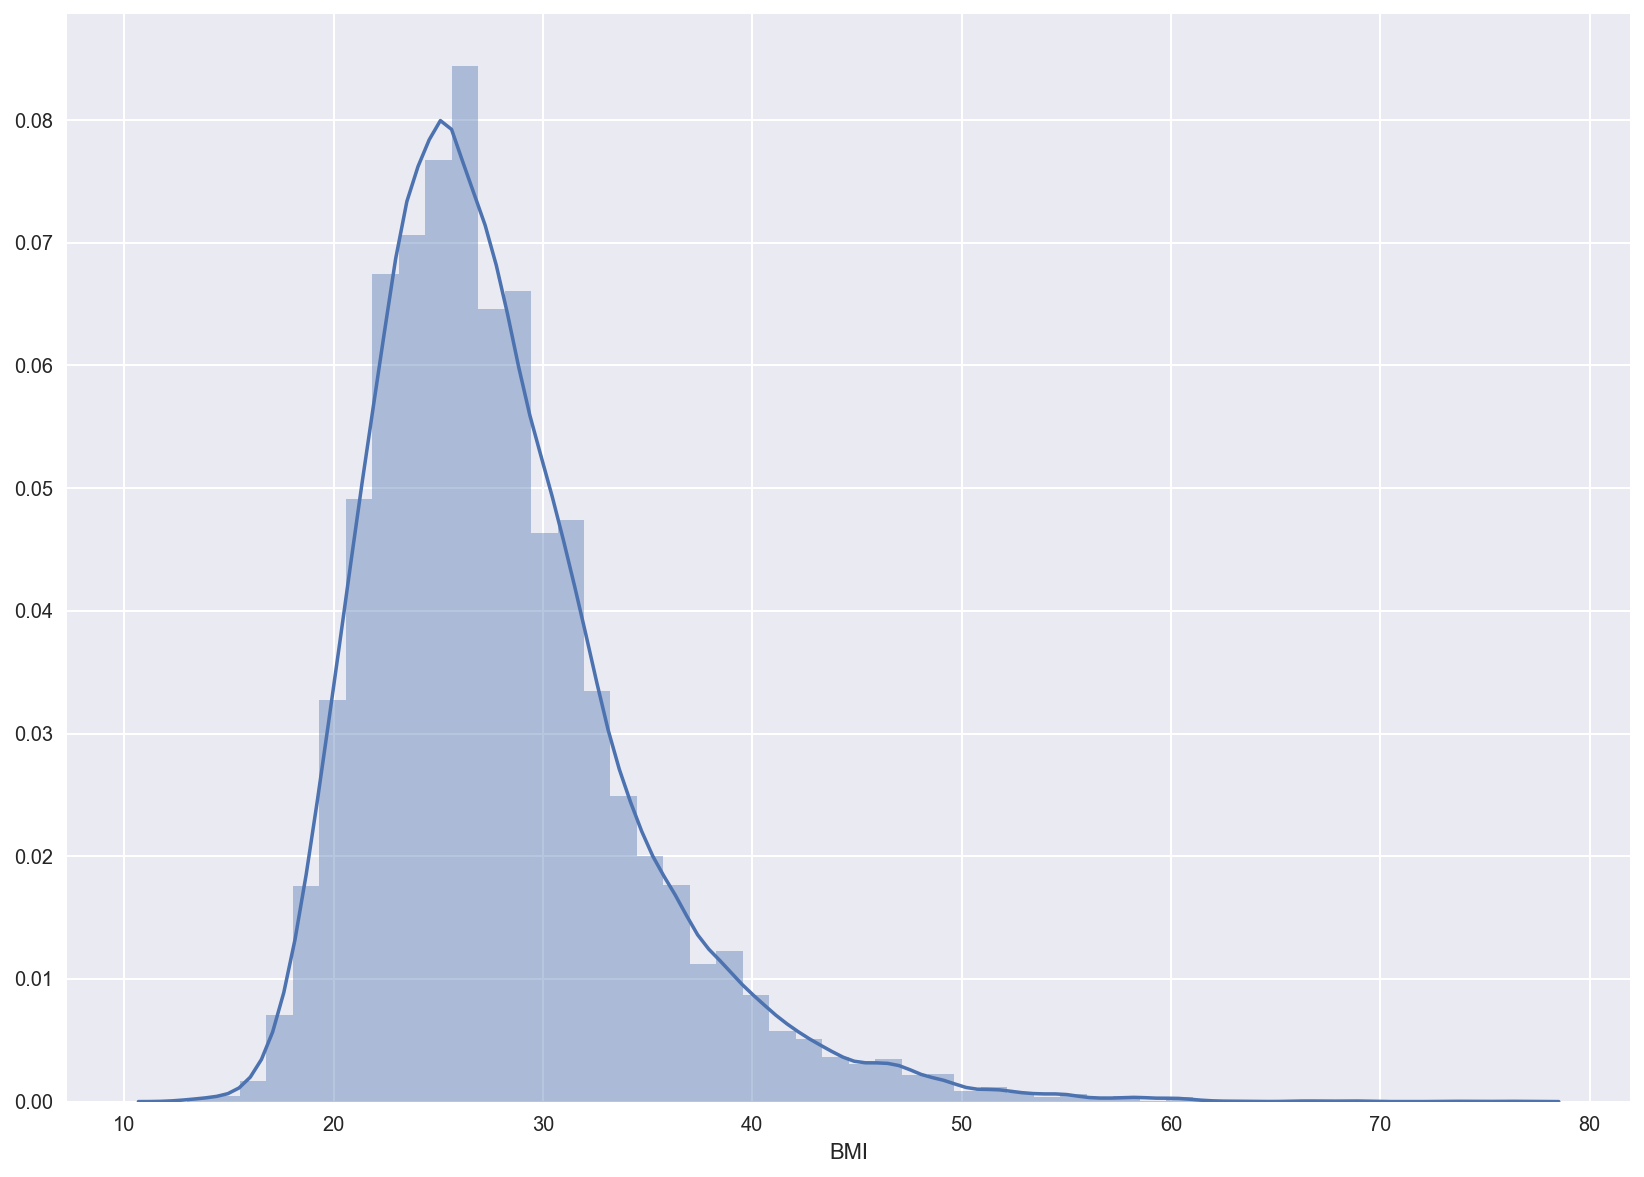

In [5]:
f, ax = plt.subplots(figsize=(14, 10))

sns.distplot(df_atus['BMI'])

plt.show()

In [6]:
# Check for normal distribution
stat, pval = scipy.stats.normaltest(df_atus['BMI'])
stat, pval

(4806.5777148218449, 0.0)

Because pval=0.0, we reject null hypothesis that the data are normally distributed. As evident in the histogram, the distribution is right-skewed with two modes.

In [7]:
df_atus['BMI'].mode()

0    25.8
dtype: float64

In [8]:
df_atus['BMI'].median()

26.6

For BMI, the mode is at 25.8, the median is at 26.6, and the interquartile range (IQR) is 30.5-23.4 = 7.1
On the BMI scale, 25 to 29.9 is considered overweight, while a BMI of >30 is considered obese.

/Users/hannes/miniconda2/envs/cogs108/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


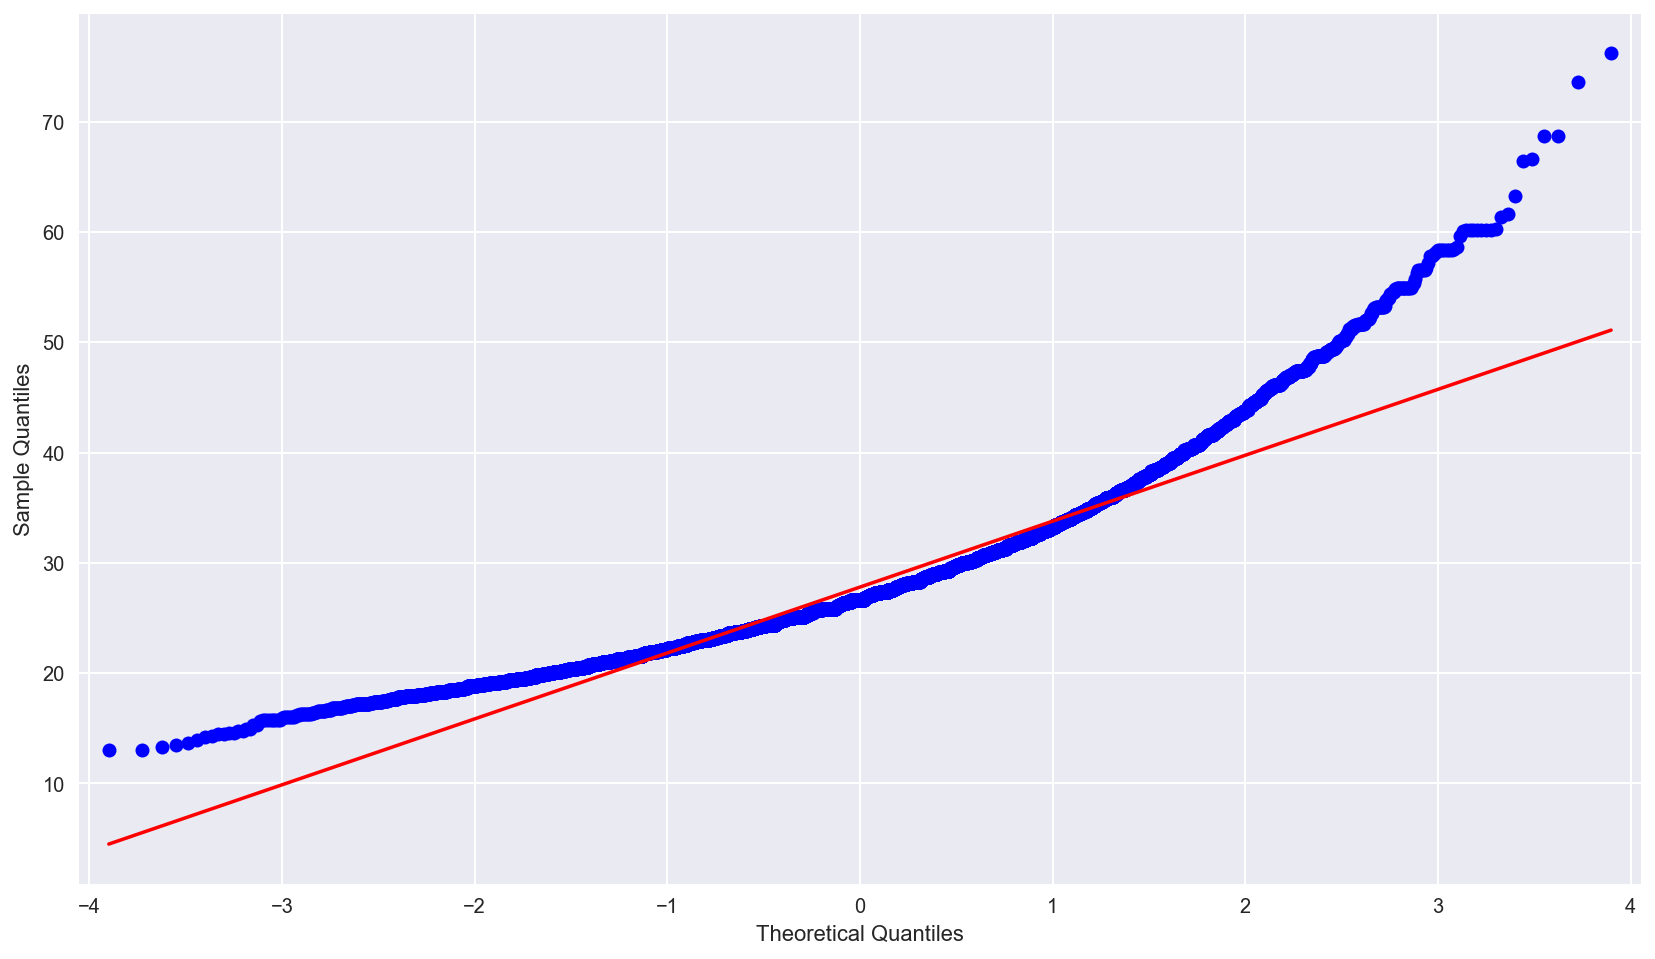

In [9]:
import statsmodels.api as sm

fig = sm.qqplot(df_atus['BMI'], line='r')
plt.show()

Though the earlier normaltest – based on D'Agostino and Pearson's test that combines skew and kurtosis for a test of normality – rejected with 100% certainty that the distribution was a normal distribution, the Q-Q plot reveals a more nuanced picture.
The Q-Q plot shows that the BMI resembles a right-skewed normal distribution.

### Spearman correlation matrix of candidate continuous features

To get an intuition for correlations between categorical features – which, in addition to not being continuous, may not have linear relationships – below is a correlation matrix generated using Spearman's rank correlation coefficient.

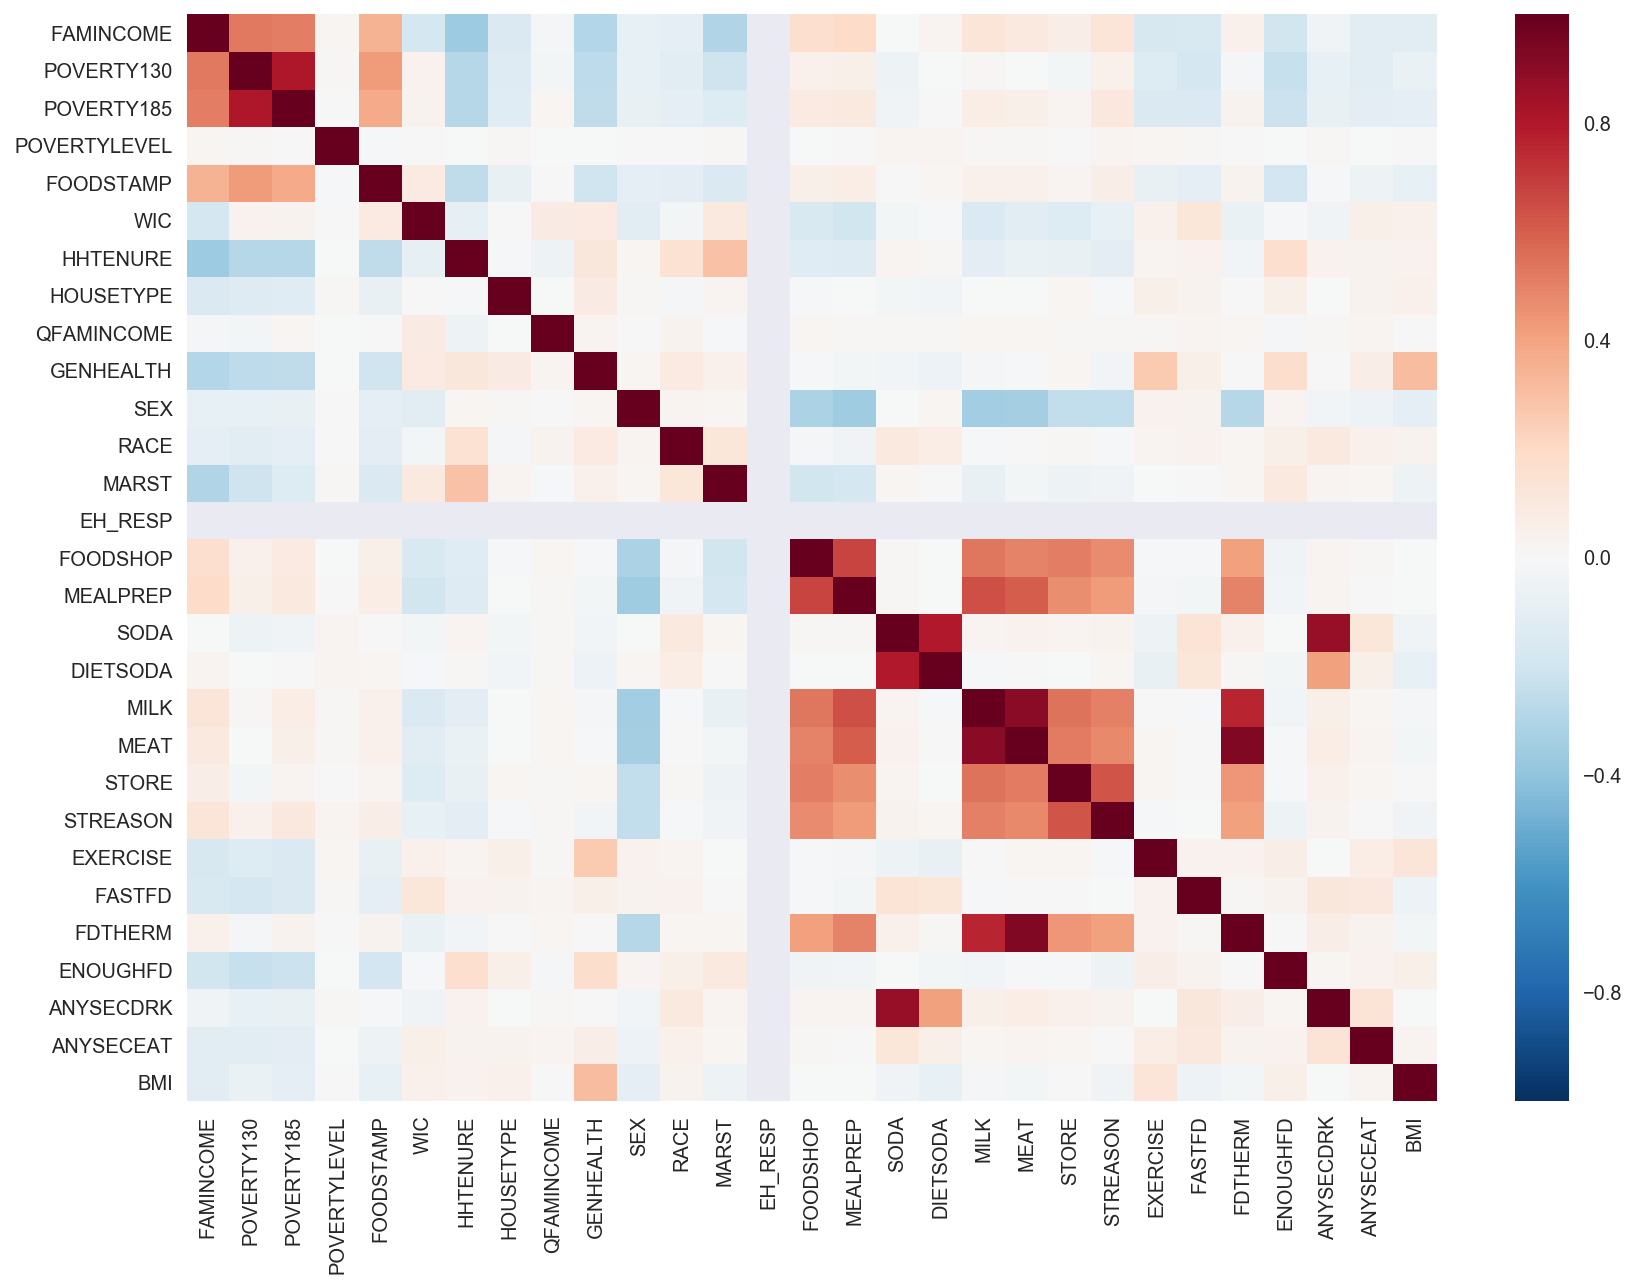

In [11]:
categorical_corrmat = (df_atus[CATEGORICAL_FEATURES + ['BMI']]).corr(method='spearman')

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(categorical_corrmat)
plt.show()

### Pearson correlation matrix of candidate continuous features

Since Pearson correlation only works with continuous variables, only such features have been visualized below.

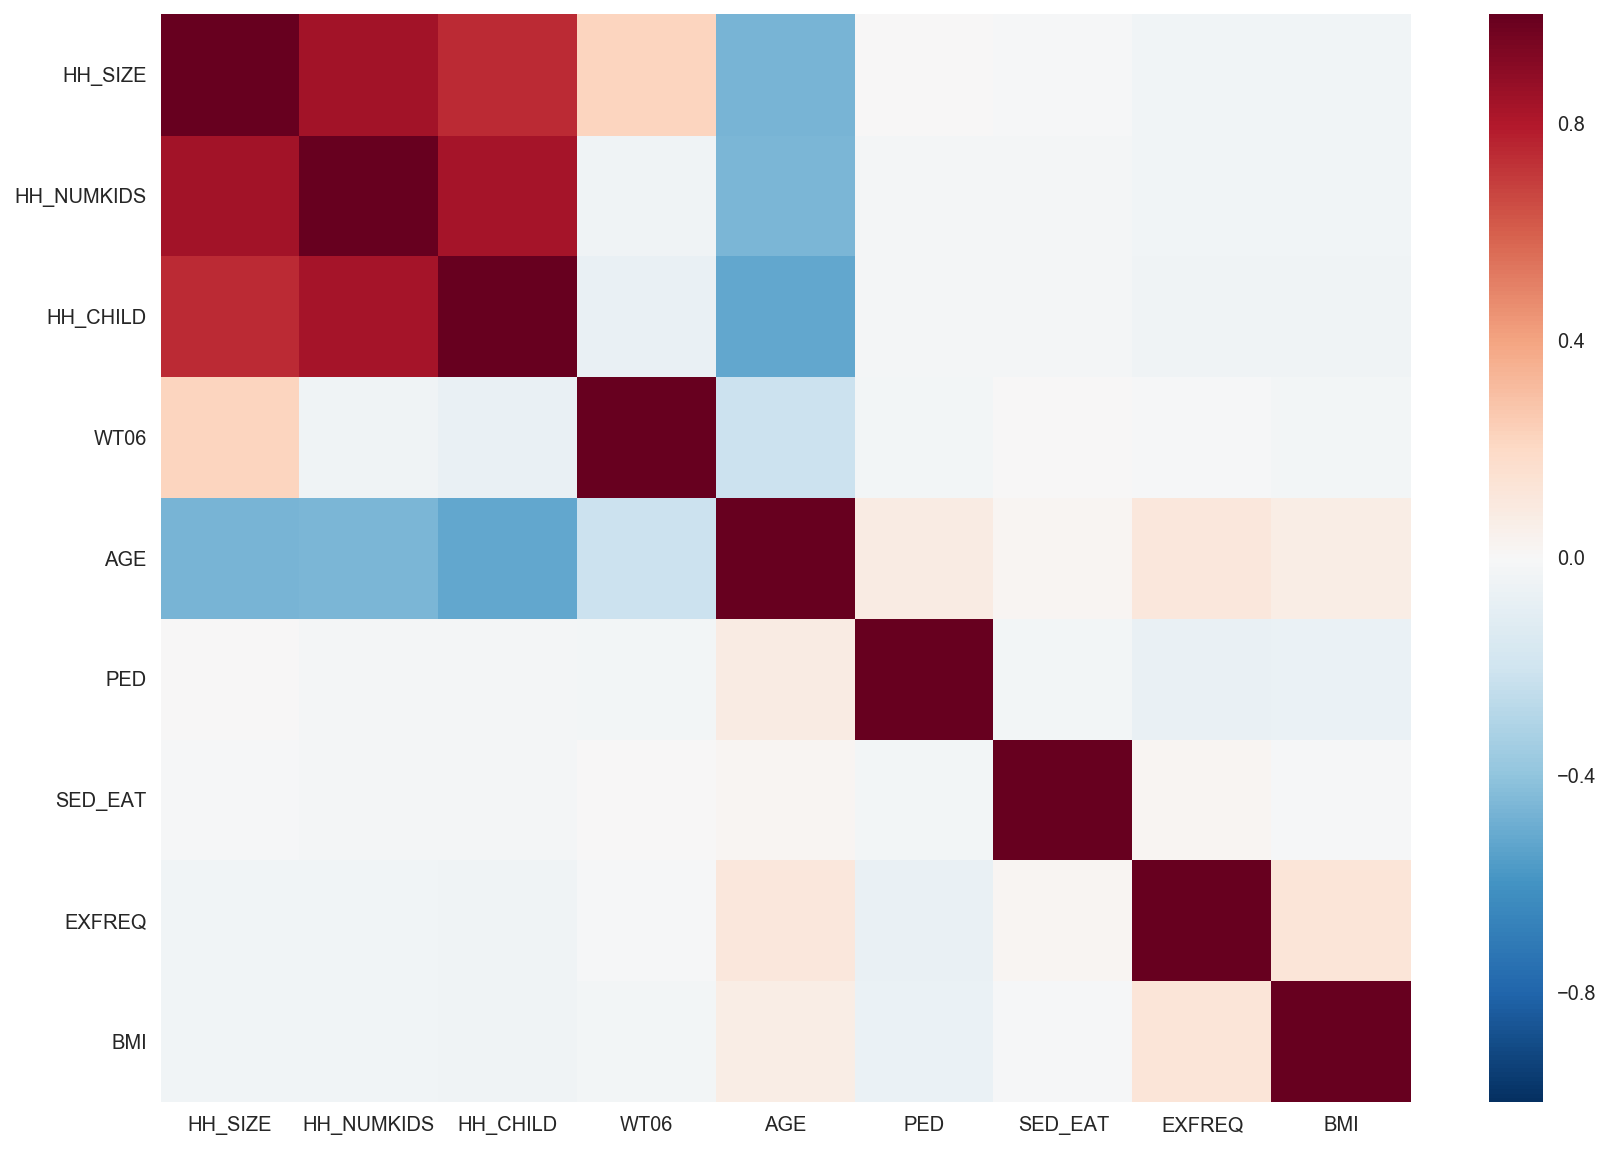

In [12]:
corrmat = (df_atus[CONTINUOUS_FEATURES + ['BMI']]).corr()

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat)
plt.show()

## Data Analysis and Results

## Conclusions / Discussion